In [1594]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns


#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf

In [1606]:
def difference(series, order=1):
    """
    Apply differencing to a time series.
    If order > 1, difference repeatedly order times.
    """
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    """
    Invert a single differencing step.
    last_original is the last known observation before differencing.
    differenced is the differenced value to be inverted.
    """
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    """
    Create AR and MA features based on specific lists of lags.
    AR features: lagged values of the differenced series.
    MA features: lagged residuals (initialized as zeros and replaced after fitting).
    
    p_lags: list of AR lags (e.g. [1,3,5]) determined from PACF
    q_lags: list of MA lags (e.g. [2,4]) determined from ACF
    """
    # AR lags
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    # MA lags - initially zero or NaN, will be filled after we get residuals
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    # Combine AR and MA features
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar
    
    # Drop rows with NaN due to lagging
    X = X.dropna()
    y = series.loc[X.index]
    return X, y

def myARIMA(p, i, q, df):
    """
    Fit an ARIMA model to the given time series `df` using specified AR and MA lags.
    p: list of AR lags (from PACF significance)
    i: order of differencing
    q: list of MA lags (from ACF significance)
    df: Pandas Series of the time series values.
    
    Returns:
    model_dict: A dictionary containing the fitted model information.
    """
    # Ensure df is a series
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    original_series = df.copy()
    
    # Difference the series i times
    differenced_series = difference(df, order=i)
    
    # Create initial AR and placeholder MA features
    X, y = create_lag_features(differenced_series, p, q)
    
    # Initialize model
    model = LinearRegression()
    
    # If no MA terms, just fit once
    if len(q) == 0:
        model.fit(X, y)
        residuals = y - model.predict(X)
    else:
        # Step 1: Fit AR-only model
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        model.fit(X[ar_cols], y)
        residuals = y - model.predict(X[ar_cols])
        
        # Now fill in the MA features with lagged residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)
        
        # Drop rows with NaN after adding residuals
        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        
        # Refit with AR+MA
        model.fit(X, y)
        residuals = y - model.predict(X)
    
    # Calculate log-likelihood
    n = len(residuals)
    sigma2 = np.var(residuals)  # Variance of residuals
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)
        
    # Store model parameters
    coef = model.coef_
    intercept = model.intercept_
    
    # Determine how many historical values we need for forecasting
    # For AR, we need max(p); for MA, we need max(q)
    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)
    
    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'model': model,
        'intercept': intercept,
        'coef': coef,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,   # Storing the training features
        'y_train': y,   # Storing the training target
        # Store enough original and differenced values for future predictions
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [1621]:
from scipy.optimize import minimize

def difference(series, order=1):
    """
    Apply differencing to a time series.
    """
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def create_lag_features(series, p_lags, q_lags):
    """
    Create lagged AR and MA features based on the specified lags.
    """
    # AR lags
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    # MA lags - initially zero or NaN, will be filled after we get residuals
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    # Combine AR and MA features
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar
    
    # Drop rows with NaN due to lagging
    X = X.dropna()
    y = series.loc[X.index]
    return X, y

def negative_log_likelihood(params, y, X, p_lags, q_lags):
    """
    Calculate the negative log-likelihood of the ARIMA model given parameters.
    """
    # Split parameters into AR, MA, and intercept
    intercept = params[0]
    ar_params = params[1:1+len(p_lags)]
    ma_params = params[1+len(p_lags):]
    
    # Initialize residuals
    residuals = np.zeros_like(y)
    
    # Calculate predictions and residuals iteratively
    for t in range(max(p_lags + q_lags), len(y)):
        ar_part = np.dot(ar_params, X.iloc[t, :len(p_lags)])
        ma_part = np.dot(ma_params, residuals[t - np.array(q_lags)])
        prediction = intercept + ar_part + ma_part
        residuals[t] = y[t] - prediction
    
    # Calculate log-likelihood assuming Gaussian residuals
    sigma2 = np.var(residuals)
    nll = 0.5 * len(y) * np.log(2 * np.pi * sigma2) + 0.5 * np.sum(residuals**2) / sigma2
    return nll

def myARIMA(p, i, q, df):
    """
    Fit an ARIMA model to the given time series `df` using specified AR and MA lags.
    """
    # Ensure df is a series
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    original_series = df.copy()
    
    # Difference the series i times
    differenced_series = difference(df, order=i)
    
    # Create AR and MA features
    X, y = create_lag_features(differenced_series, p, q)
    
    # Initialize parameter guesses
    intercept_guess = y.mean()
    ar_guesses = np.zeros(len(p))
    ma_guesses = np.zeros(len(q))
    initial_params = np.concatenate([[intercept_guess], ar_guesses, ma_guesses])
    
    # Optimize using L-BFGS-B
    result = minimize(
        negative_log_likelihood,
        initial_params,
        args=(y.values, X, p, q),
        method='L-BFGS-B'
    )
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    # Extract fitted parameters
    fitted_params = result.x
    intercept = fitted_params[0]
    coef = fitted_params[1:]
    log_likelihood = -result.fun  # The minimized value is the negative log-likelihood
    
    # Calculate residuals
    residuals = y.values - (intercept + X @ fitted_params[1:])

    # Determine how many historical values we need for forecasting
    # For AR, we need max(p); for MA, we need max(q)
    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)
    
    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'intercept': intercept,
        'coef': coef,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [1597]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [1598]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

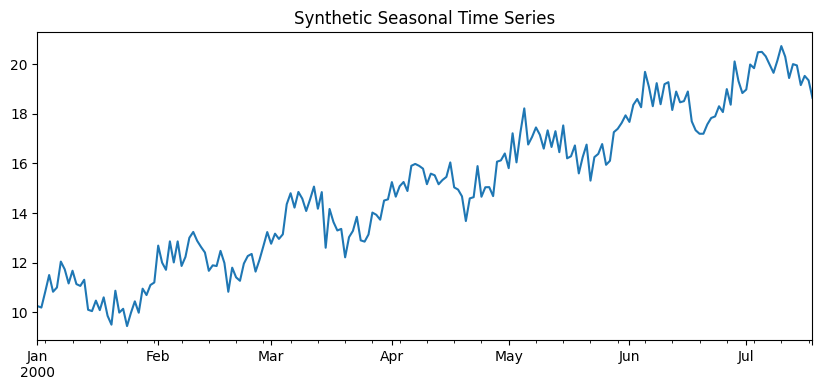

In [1599]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a time index
n_points = 200
time_index = pd.date_range(start='2000-01-01', periods=n_points, freq='D')

# Generate a seasonal pattern (sine wave)
seasonality_period = 30
offset = 10
seasonal_pattern = np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)

# Add some trend (e.g., linear upward trend)
trend = 0.05 * np.arange(n_points)

# Add random noise
noise = np.random.normal(loc=0.0, scale=0.5, size=n_points)

# Combine these components
data = offset + trend + seasonal_pattern + noise

# Create a Pandas Series
df = pd.Series(data, index=time_index, name='value')

# Plot the series
df.plot(title='Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

#print(df.head())

In [1600]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df)

# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [1601]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(df)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


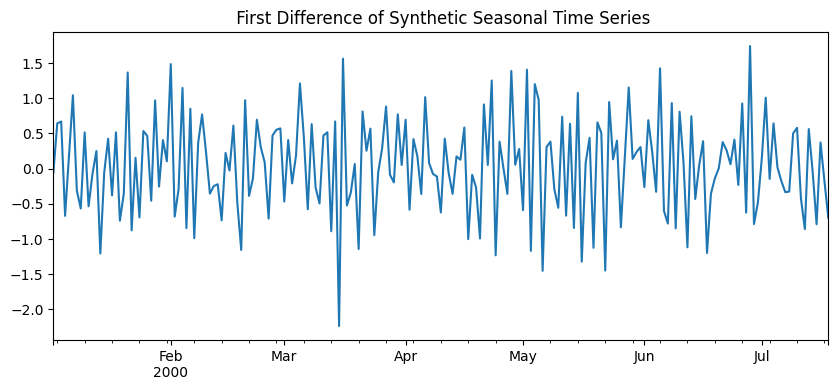

In [1602]:
df_diffed = difference(df)

df_diffed.plot(title=' First Difference of Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

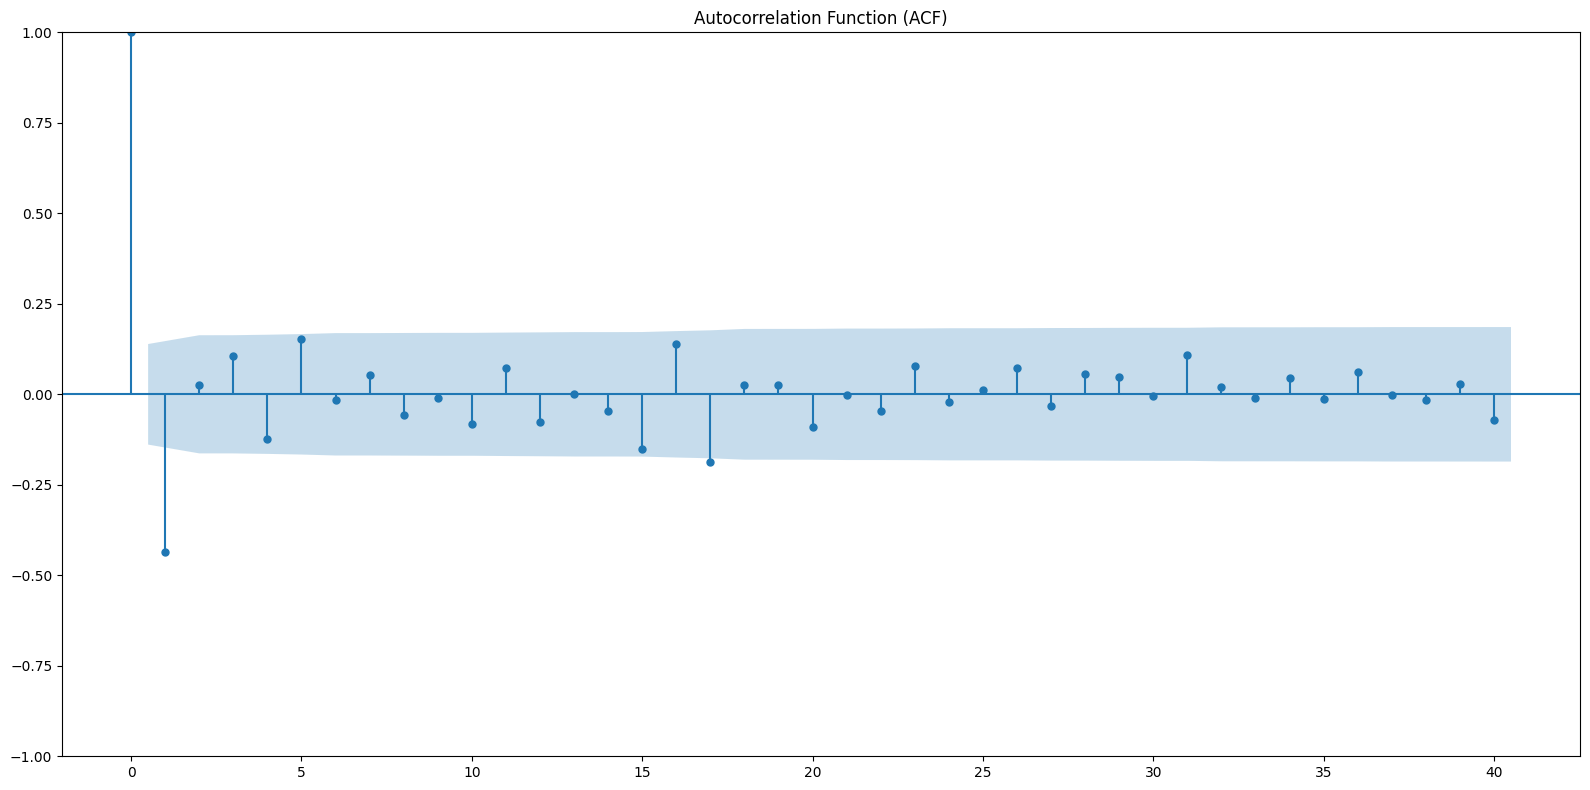

Significant ACF lags:
[1, 17]


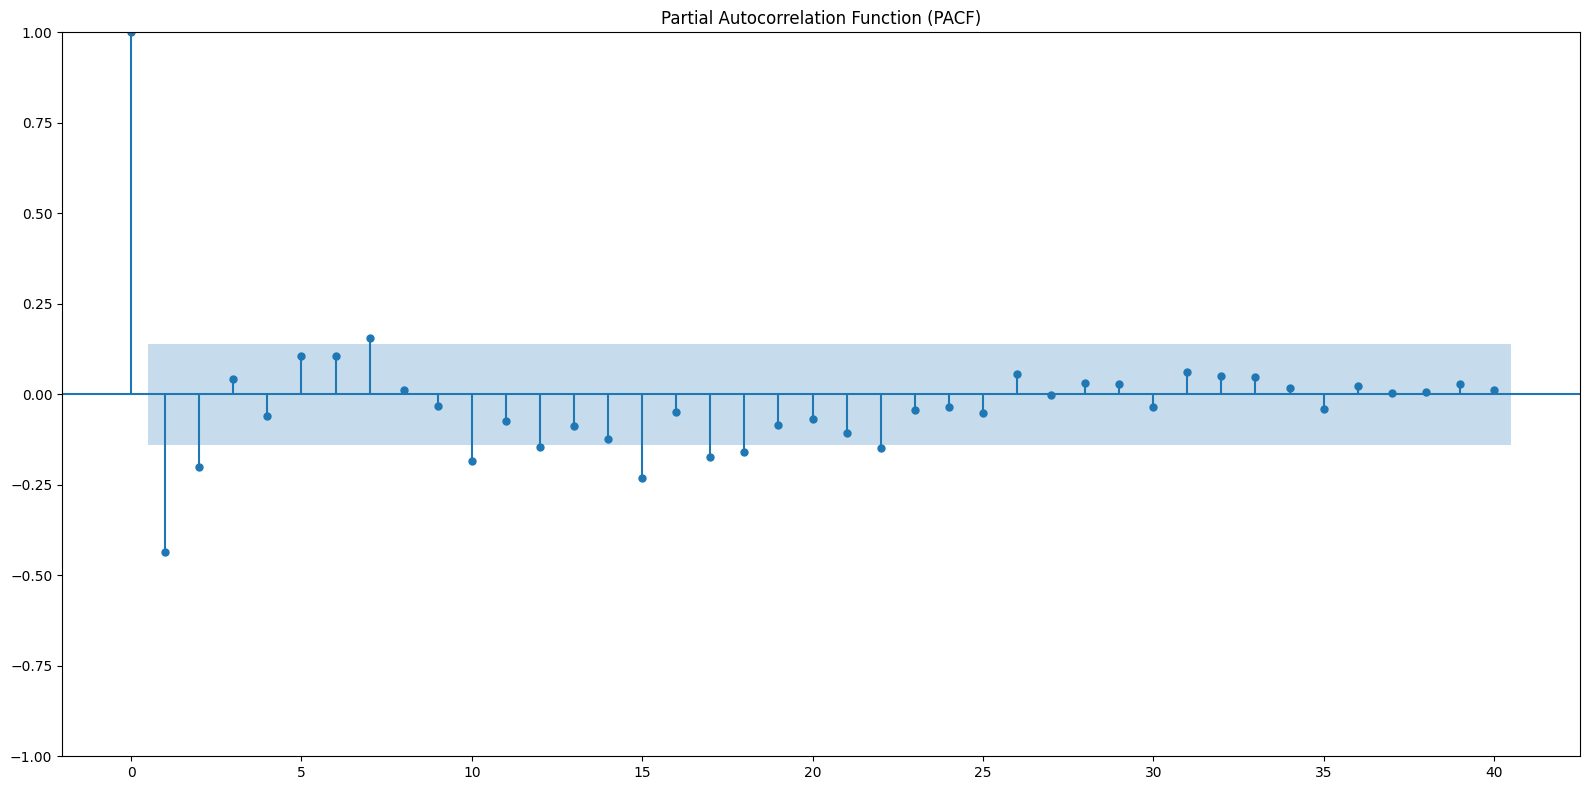

Significant PACF lags:
[1, 2, 7, 10, 12, 15, 17, 18, 21, 22, 25]


In [1603]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(df_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(df_diffed)

print("Significant PACF lags:")
print(p)

In [1622]:
p = list(range(1,26))
q = [1]

# Fit the ARIMA model
model_dict = myARIMA(p=[1,2], i=1, q=q, df=df)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
log_likelihood = model_dict['log_likelihood']
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)


#print(f"Intercept: {intercept:.4f}")
print("Log-Likelihood:", model_dict['log_likelihood'])

print("Coefficients:")
print("Intercept:", model_dict['intercept'])
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


Log-Likelihood: -180.20122757161684
Coefficients:
Intercept: 0.09140518630043531
lag_1: -0.9450
lag_2: -0.3828
ma_1: 0.4351


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


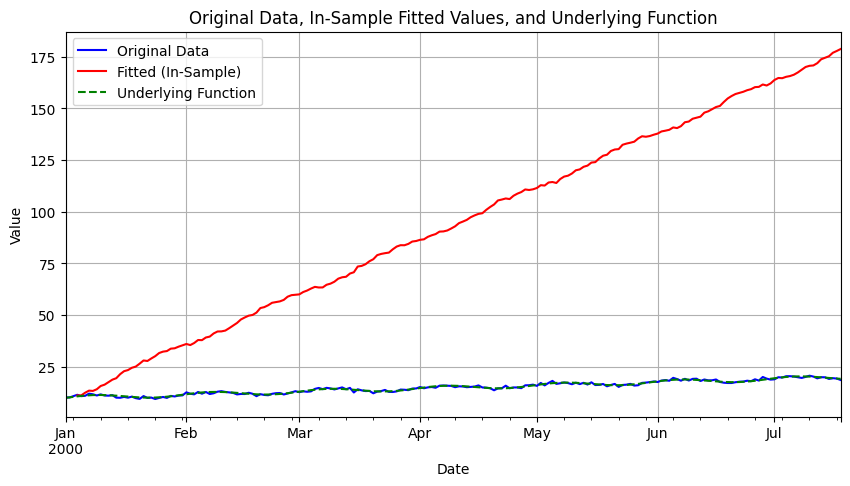

In [1623]:
#model = model_dict['model']

# Manually assign these values to the custom model
model = LinearRegression()
model.coef_ = np.array([-0.945, -0.3828, 0.4351])
model.intercept_ = 0.914

X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

# Invert differencing (assuming i=1 for simplicity)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented in this example.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
#original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# ---------------------------------------------------------
# Plot the original data, fitted values, and underlying sine function

extended_index = original_series.index
n_points = len(extended_index)

seasonality_period = 30
underlying_seasonal = np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)
trend = 0.05 * np.arange(n_points)
offset = 10
underlying_pattern = offset + trend + underlying_seasonal
underlying_series = pd.Series(underlying_pattern, index=extended_index, name='Underlying Function')

plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')
underlying_series.plot(label='Underlying Function', color='green', linestyle='--')

plt.title("Original Data, In-Sample Fitted Values, and Underlying Function")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


2000-07-19    19.128324
2000-07-20    19.243148
2000-07-21    19.565309
2000-07-22    19.637968
2000-07-23    19.375250
                ...    
2000-10-22    24.405121
2000-10-23    24.567033
2000-10-24    24.747670
2000-10-25    24.933876
2000-10-26    25.122579
Freq: D, Name: Forecast, Length: 100, dtype: float64


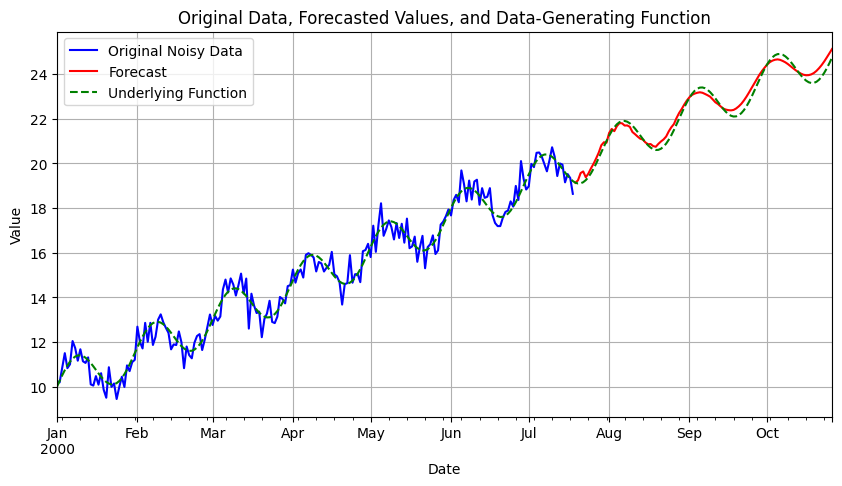

In [1617]:
preds = forecast(model_dict, steps=100)

# Get the last timestamp from the original series
last_date = df.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
print(pred_series)

# ---------------------------------------------------------
# Plot the underlying function (the deterministic part without noise)
# We know the original generation parameters (from previous context).
# Recreate them for the entire period + forecast:

original_length = len(df)
forecast_length = len(preds)
extended_length = original_length + forecast_length

extended_index = pd.date_range(start=df.index[0], periods=extended_length, freq='D')

underlying_seasonal = np.sin(2 * np.pi * np.arange(extended_length) / seasonality_period)
trend = 0.05 * np.arange(extended_length)
underlying_pattern = offset + trend + underlying_seasonal

underlying_series = pd.Series(underlying_pattern, index=extended_index, name='Underlying Function')

# ---------------------------------------------------------
# Plot all three: original data, forecast, and underlying function

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, label='Original Noisy Data', color='blue')
pred_series.plot(ax=ax, label='Forecast', color='red')
underlying_series.plot(ax=ax, label='Underlying Function', color='green', linestyle='--')

plt.title("Original Data, Forecasted Values, and Data-Generating Function")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [1620]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(df, order=(2, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  200
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -183.872
Date:                Mon, 16 Dec 2024   AIC                            375.743
Time:                        14:33:38   BIC                            388.916
Sample:                    01-01-2000   HQIC                           381.075
                         - 07-18-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1295      0.188     -5.996      0.000      -1.499      -0.760
ar.L2         -0.4323      0.082     -5.285      0.000      -0.593      -0.272
ma.L1          0.6584      0.201      3.275      0.0

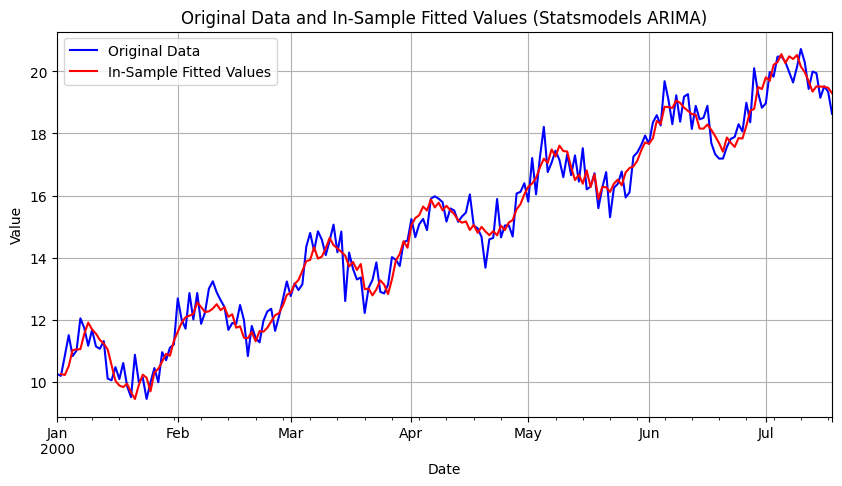

In [1619]:
# Get the in-sample fitted values
fitted_values = model_fit.fittedvalues[1:]

# Since the ARIMA model uses differencing (I(1)), the fitted values correspond to the differenced series.
# We'll invert the differencing to align the fitted values with the original series.
fitted_original_values = df.iloc[0] + fitted_values.cumsum()

# Plot the original data and the fitted values
plt.figure(figsize=(10, 5))
df.plot(label='Original Data', color='blue')
fitted_values.plot(label='In-Sample Fitted Values', color='red')

plt.title("Original Data and In-Sample Fitted Values (Statsmodels ARIMA)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

2000-07-19    19.039875
2000-07-20    18.888188
2000-07-21    18.884641
2000-07-22    18.954225
2000-07-23    18.877163
                ...    
2000-10-22    18.912401
2000-10-23    18.912401
2000-10-24    18.912401
2000-10-25    18.912401
2000-10-26    18.912401
Freq: D, Name: Forecast, Length: 100, dtype: float64


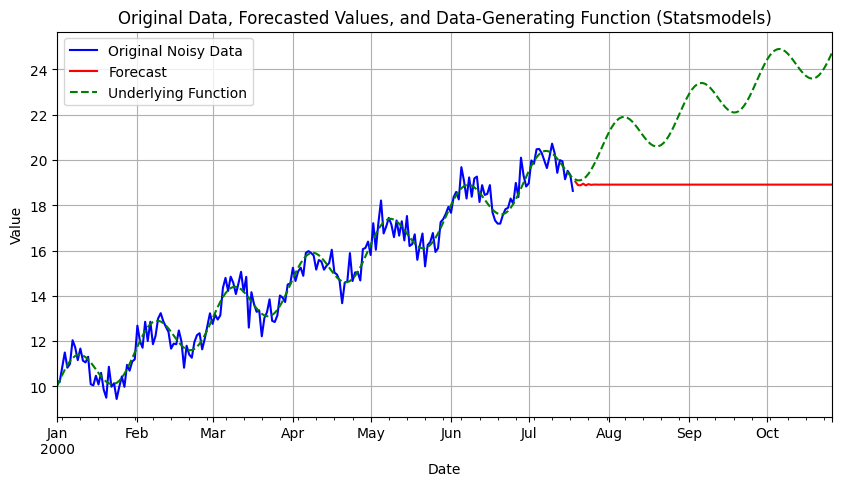

In [ ]:
forecast_steps = 100
forecast_results = model_fit.get_forecast(steps=forecast_steps)
# Forecasted values
preds = forecast_results.predicted_mean

# Get the last timestamp from the original series
last_date = df.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
print(pred_series)

# ---------------------------------------------------------
# Plot the underlying function (the deterministic part without noise)
# We know the original generation parameters (from previous context).
# Recreate them for the entire period + forecast:

original_length = len(df)
forecast_length = len(preds)
extended_length = original_length + forecast_length

extended_index = pd.date_range(start=df.index[0], periods=extended_length, freq='D')

underlying_seasonal = np.sin(2 * np.pi * np.arange(extended_length) / seasonality_period)
trend = 0.05 * np.arange(extended_length)
underlying_pattern = offset + trend + underlying_seasonal

underlying_series = pd.Series(underlying_pattern, index=extended_index, name='Underlying Function')

# ---------------------------------------------------------
# Plot all three: original data, forecast, and underlying function

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, label='Original Noisy Data', color='blue')
pred_series.plot(ax=ax, label='Forecast', color='red')
underlying_series.plot(ax=ax, label='Underlying Function', color='green', linestyle='--')

plt.title("Original Data, Forecasted Values, and Data-Generating Function (Statsmodels)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Missing values: 1
date
2017-02-05    83.54
2017-02-12    82.52
2017-02-19    81.76
2017-02-26    81.08
2017-03-05    82.46
Name: PRC, dtype: float64


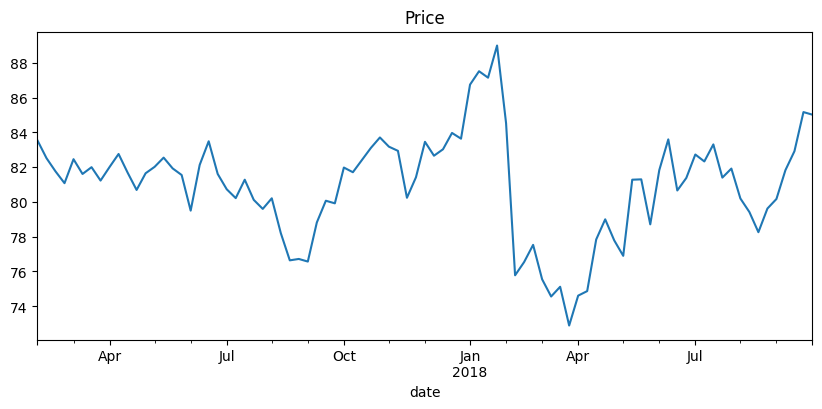

In [ ]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)

# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
s = df['PRC']

f = 'W-SUN' # 'W-SUN' means week ending on Sunday
s = s.resample(f).last()

# check for missing values
print("Missing values:", s.isnull().sum())
# remove missing values
s = s.dropna()

start_date = '2017-1-30'
end_train_date = '2018-9-30'

# Filter the data according to the date range
s_train = s[(s.index >= start_date) & (s.index <= end_train_date)]
s_test = s[(s.index >= s_train.index[-1])]

print(s_train.head())
s_train.describe()

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [ ]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [ ]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


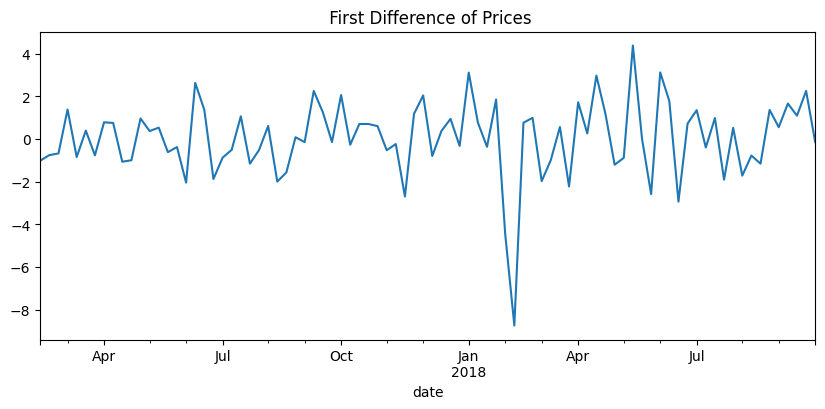

In [ ]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

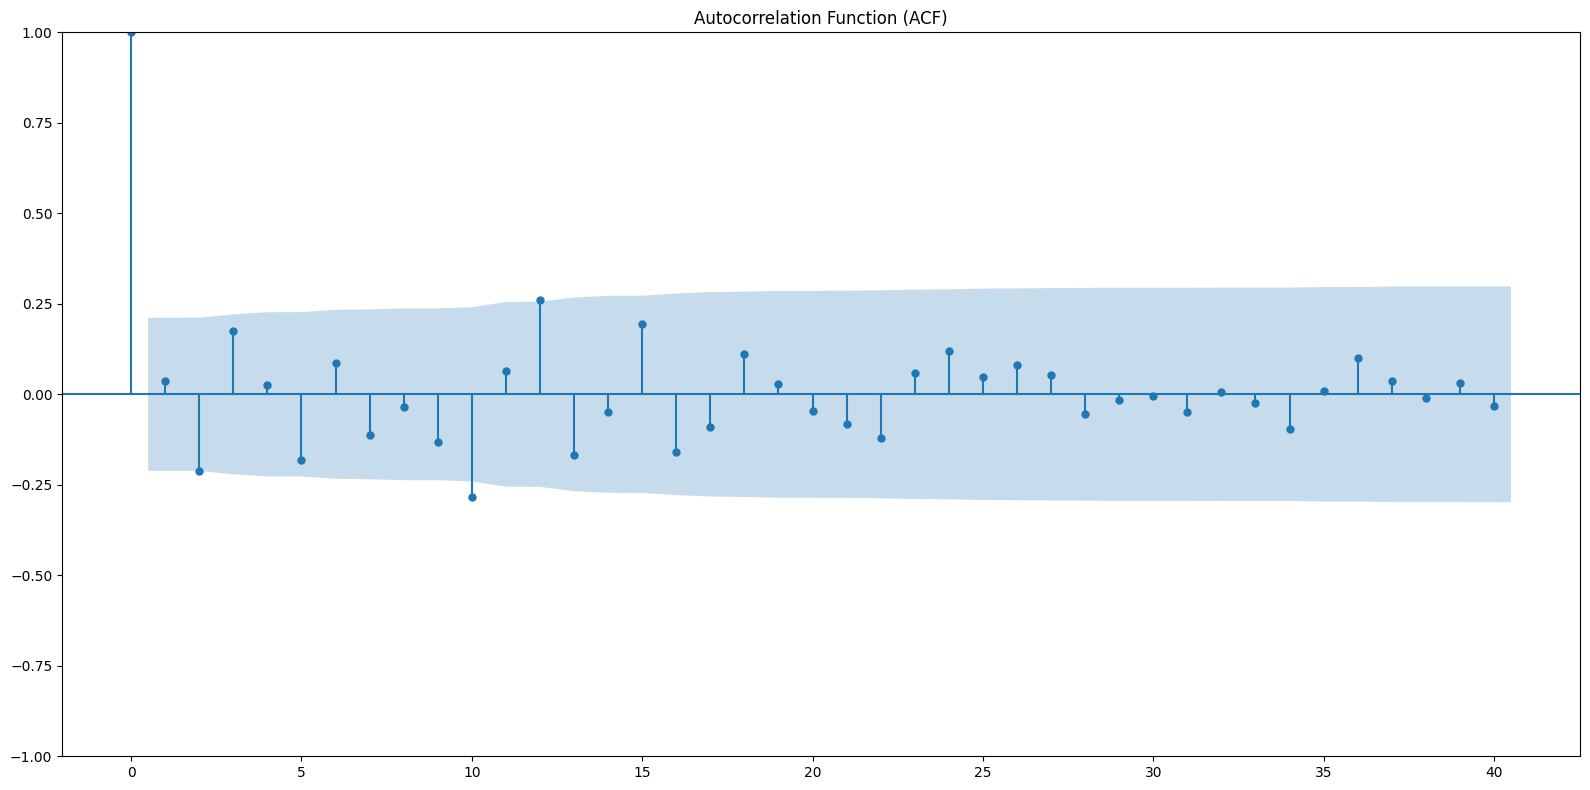

Significant ACF lags:
[2, 10, 12]


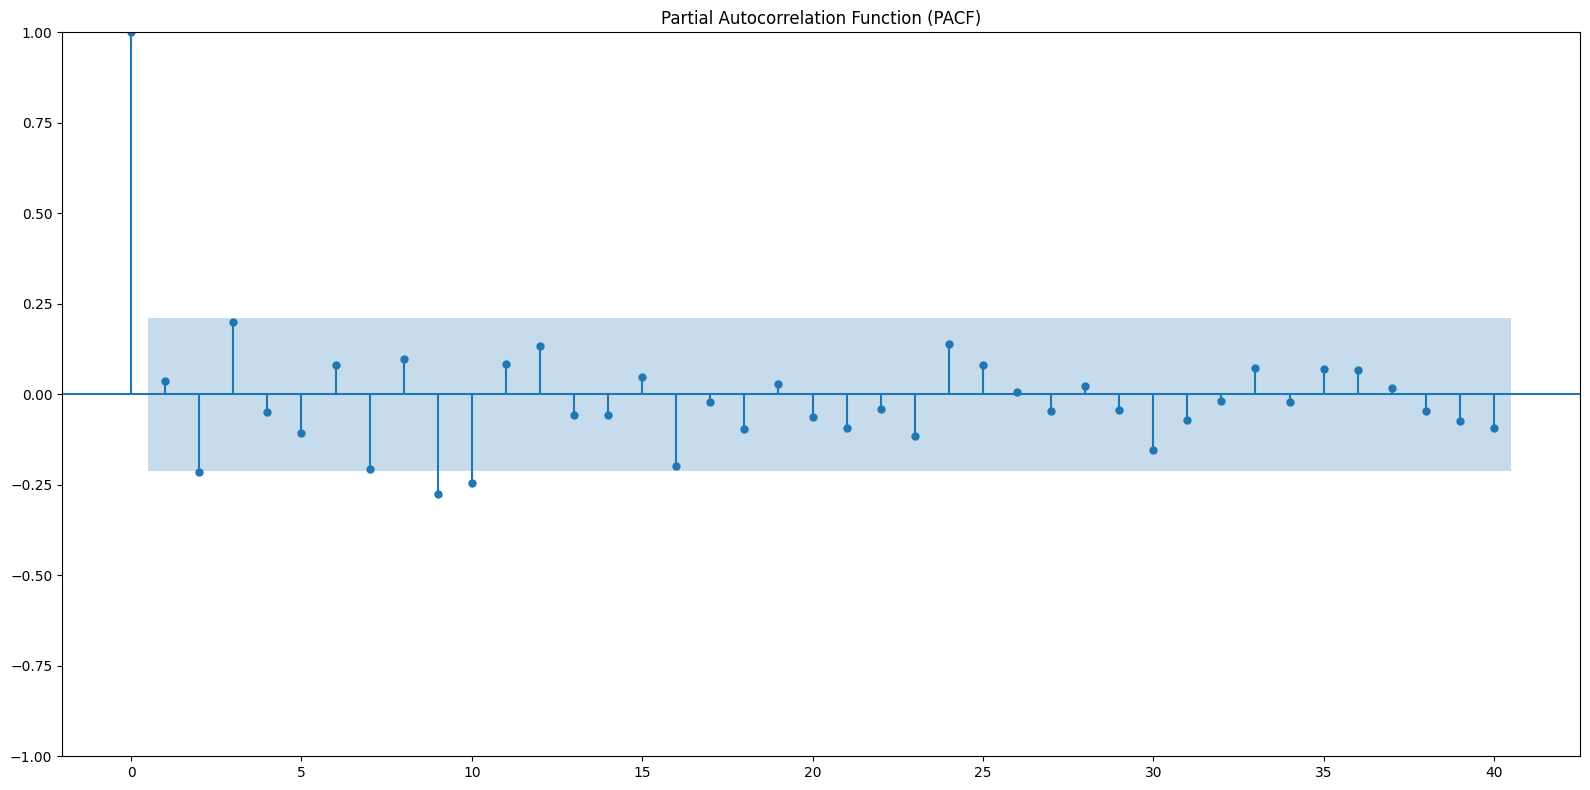

Significant PACF lags:
[2, 7, 9, 10, 16, 24, 30, 39, 40]


In [ ]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [ ]:
p = list(range(1, 30))
q = [1, 2, 3]

# Fit the ARIMA model
model_dict = myARIMA(p=p, i=1, q=q, df=s_train)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


Learned Parameters:
Intercept: -0.4199
Coefficients:
lag_1: 2.4194
lag_2: -0.3961
lag_3: 2.4059
lag_4: -0.7640
lag_5: 0.0453
lag_6: 0.8236
lag_7: -0.8753
lag_8: 1.8615
lag_9: -1.3279
lag_10: 1.4549
lag_11: 0.4014
lag_12: 0.5169
lag_13: 0.5943
lag_14: -0.7719
lag_15: 1.1008
lag_16: -0.7997
lag_17: 1.2449
lag_18: -0.5242
lag_19: 0.6119
lag_20: 0.2877
lag_21: -0.0731
lag_22: 0.7617
lag_23: -0.3695
lag_24: 0.9369
lag_25: -0.2496
lag_26: 0.0187
lag_27: -0.0980
lag_28: -0.0874
lag_29: 0.2745
ma_1: -2.3375
ma_2: -0.4339
ma_3: -1.7144


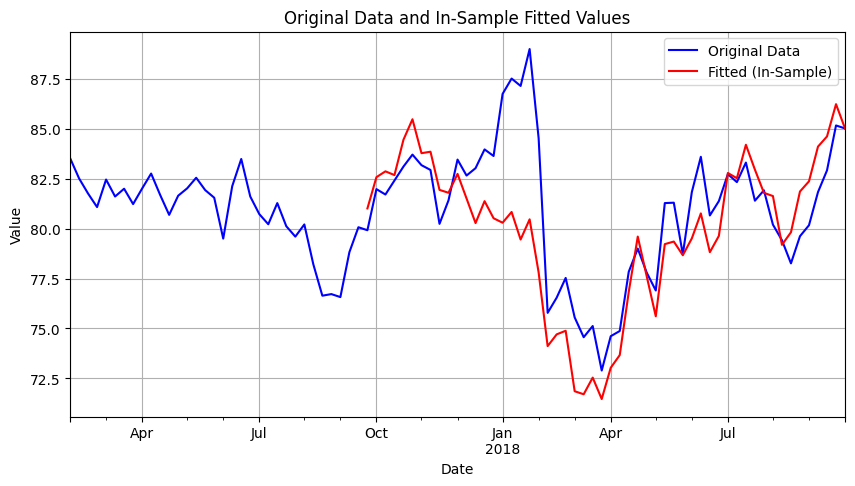

In [ ]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


2018-10-07    85.256270
2018-10-14    83.320177
2018-10-21    76.905201
2018-10-28    63.277684
2018-11-04    28.976037
Freq: W-SUN, Name: Forecast, dtype: float64


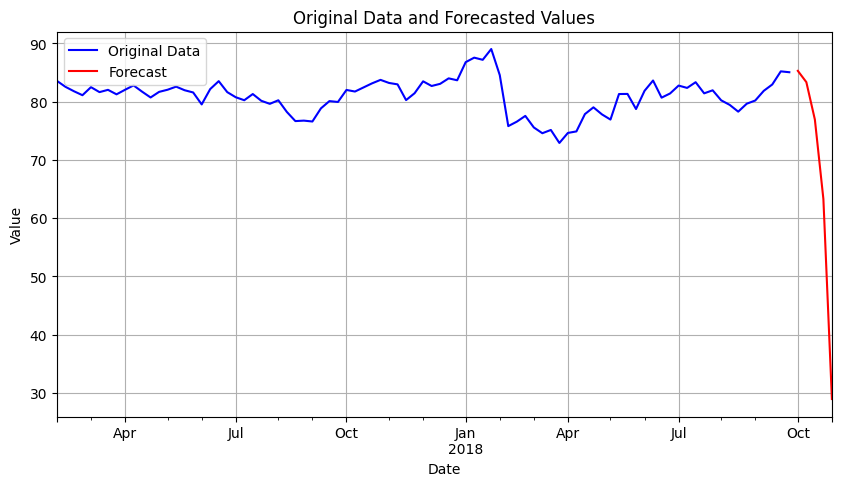

In [ ]:
# Assume that model_dict, df, and forecast() are already defined.
forecast_steps = 5
preds = forecast(model_dict, forecast_steps)

# Get the last timestamp from the original series
last_date = s_train.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')
future_dates = pd.date_range(s_train.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Original Data', color='blue')
pred_series.plot(ax=ax, label='Forecast', color='red')

plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
